In [1]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import terratorch
import torch
import torchgeo 
%matplotlib inline

import os
import tempfile

import timm
import torch
from lightning.pytorch import Trainer
import tqdm as notebook_tqdm

#import geopandas as gpd
import pandas as pd

import sys
sys.path.append('../')


import utils.basics as bsc
import utils.plotting as pt

import importlib
importlib.reload(pt)

%load_ext autoreload
%autoreload 2

/Users/felix/miniconda3/envs/CHM/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# === Paths ===
INPUT_FOLDER = "../data/03_training"

def load_and_split_patches(site, patch_size=32, test_size=0.2, random_state=42):
    """
    Load S2 and ALS patches for a given site, split into train/test sets.

    Parameters:
    - site: int (1 or 2)
    - patch_size: int
    - test_size: float
    - random_state: int

    Returns:
    - X_train, X_test, y_train, y_test
    """
    s2_patches = np.load(os.path.join(INPUT_FOLDER, f"S2_site{site}_px{patch_size}.npy"))
    als_patches = np.load(os.path.join(INPUT_FOLDER, f"ALS_site{site}_px{patch_size}.npy"))
    X_train, X_test, y_train, y_test = train_test_split(
        s2_patches, als_patches, test_size=test_size, random_state=random_state
    )
    print(f"Site {site}: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Site {site}: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    return X_train, X_test, y_train, y_test

# Execute for site 1 and 2
X_train1, X_test1, y_train1, y_test1 = load_and_split_patches(site=1)
X_train2, X_test2, y_train2, y_test2 = load_and_split_patches(site=2)

Site 1: X_train shape: (288, 13, 32, 32), y_train shape: (288, 32, 32)
Site 1: X_test shape: (72, 13, 32, 32), y_test shape: (72, 32, 32)
Site 2: X_train shape: (255, 13, 32, 32), y_train shape: (255, 32, 32)
Site 2: X_test shape: (64, 13, 32, 32), y_test shape: (64, 32, 32)


In [3]:
# write a function that stakcs the training and test sets for both sites
def stack_datasets(X_train1, X_test1, y_train1, y_test1, X_train2, X_test2, y_train2, y_test2):
    """
    Stack training and test sets for both sites.

    Parameters:
    - X_train1, X_test1, y_train1, y_test1: Site 1 datasets
    - X_train2, X_test2, y_train2, y_test2: Site 2 datasets

    Returns:
    - Stacked training and test sets
    """
    X_train = np.vstack((X_train1, X_train2))
    X_test = np.vstack((X_test1, X_test2))
    y_train = np.vstack((y_train1, y_train2))
    y_test = np.vstack((y_test1, y_test2))
    
    print(f"Stacked X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Stacked X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = stack_datasets(X_train1, X_test1, y_train1, y_test1, X_train2, X_test2, y_train2, y_test2)

Stacked X_train shape: (543, 13, 32, 32), y_train shape: (543, 32, 32)
Stacked X_test shape: (136, 13, 32, 32), y_test shape: (136, 32, 32)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
#from terratorch.models import resnet50
from torchgeo.models import resnet50

# Step-by-step guide for training with TerraTorch and Lightning using ResNet50 (pretrained on Sentinel-2)

# 1. Prepare PyTorch Dataset

class S2CanopyHeightDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().unsqueeze(1)  # (N, 1, 32, 32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = S2CanopyHeightDataset(X_train, y_train)
val_dataset = S2CanopyHeightDataset(X_test, y_test)

# 2. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)

# 3. Load ResNet50 with Sentinel-2 weights using terratorch
model = resnet50(pretrained=False)
# Replace the final layer for regression (output: 1 channel)
import torch.nn as nn
model.fc = nn.Conv2d(2048, 1, kernel_size=1)

# 4. LightningModule for regression
import lightning.pytorch as pl

class CanopyHeightRegressor(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = nn.MSELoss()
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# 5. Training with Lightning Trainer and progress monitoring
regressor = CanopyHeightRegressor(model)
trainer = pl.Trainer(max_epochs=20, accelerator="auto", devices="auto", log_every_n_steps=10)
trainer.fit(regressor, train_loader, val_loader)

In [11]:
%matplotlib inline

import os
import tempfile

import timm
import torch
from lightning.pytorch import Trainer

from torchgeo.datamodules import EuroSAT100DataModule
from torchgeo.models import ResNet18_Weights
from torchgeo.trainers import ClassificationTask, RegressionTask

In [27]:
batch_size = 10
num_workers = 2
max_epochs = 25
fast_dev_run = False

In [13]:
root = os.path.join(tempfile.gettempdir(), 'eurosat100')
datamodule = EuroSAT100DataModule(
    root=root, batch_size=batch_size, num_workers=num_workers, download=True
)

In [14]:
weights = ResNet18_Weights.SENTINEL2_ALL_MOCO

In [15]:
task = ClassificationTask(
    model='resnet18',
    loss='ce',
    weights=weights,
    in_channels=13,
    num_classes=10,
    lr=0.001,
    patience=5,
)

Downloading: "https://hf.co/torchgeo/resnet18_sentinel2_all_moco/resolve/5b8cddc9a14f3844350b7f40b85bcd32aed75918/resnet18_sentinel2_all_moco-59bfdff9.pth" to /Users/felix/.cache/torch/hub/checkpoints/resnet18_sentinel2_all_moco-59bfdff9.pth


100%|██████████| 42.8M/42.8M [00:05<00:00, 8.32MB/s]


In [18]:
weights.meta

{'dataset': 'SSL4EO-S12',
 'in_chans': 13,
 'model': 'resnet18',
 'publication': 'https://arxiv.org/abs/2211.07044',
 'repo': 'https://github.com/zhu-xlab/SSL4EO-S12',
 'ssl_method': 'moco',
 'bands': ['B1',
  'B2',
  'B3',
  'B4',
  'B5',
  'B6',
  'B7',
  'B8',
  'B8a',
  'B9',
  'B10',
  'B11',
  'B12']}

In [21]:
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
default_root_dir = os.path.join(tempfile.gettempdir(), 'experiments')

In [30]:
trainer = Trainer(
    accelerator=accelerator,
    default_root_dir=default_root_dir,
    fast_dev_run=fast_dev_run,
    log_every_n_steps=1,
    min_epochs=1,
    max_epochs=max_epochs,
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/felix/miniconda3/envs/CHM/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [45]:
trainer.logged_metrics

{'train_AverageAccuracy': tensor(1.),
 'train_F1Score': tensor(1.),
 'train_JaccardIndex': tensor(1.),
 'train_OverallAccuracy': tensor(1.),
 'train_loss': tensor(0.0517),
 'val_AverageAccuracy': tensor(0.5500),
 'val_F1Score': tensor(0.5500),
 'val_JaccardIndex': tensor(0.4750),
 'val_OverallAccuracy': tensor(0.5500),
 'val_loss': tensor(1.6163)}

In [31]:
trainer.fit(model=task, datamodule=datamodule)


  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ResNet           | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.852    Total estimated model params size (MB)
110       Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 6/6 [00:00<00:00, 10.35it/s, v_num=1]           

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 6/6 [00:00<00:00,  9.04it/s, v_num=1]


In [46]:
trainer.test(model=task, datamodule=datamodule)

Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 22.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_AverageAccuracy    │            0.5            │
│       test_F1Score        │            0.5            │
│     test_JaccardIndex     │    0.3976190388202667     │
│   test_OverallAccuracy    │            0.5            │
│         test_loss         │    1.0558582544326782     │
└───────────────────────────┴───────────────────────────┘

[{'test_AverageAccuracy': 0.5,
  'test_F1Score': 0.5,
  'test_JaccardIndex': 0.3976190388202667,
  'test_OverallAccuracy': 0.5,
  'test_loss': 1.0558582544326782}]

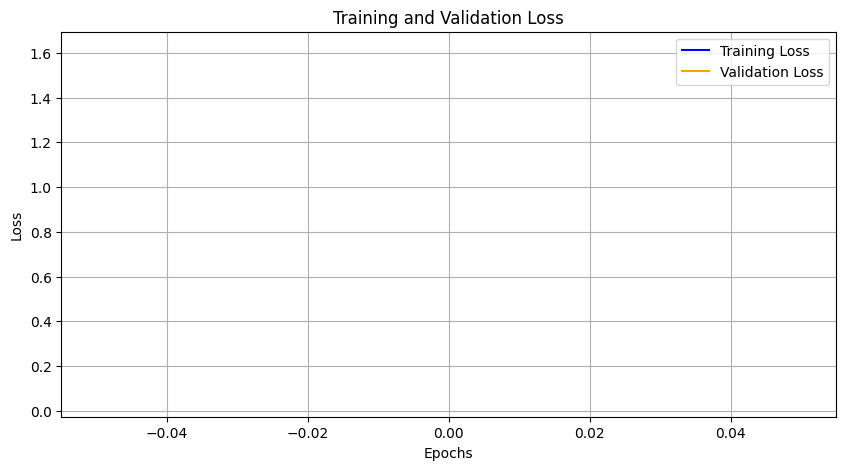

In [32]:
# now plot the training and validation loss
import matplotlib.pyplot as plt
def plot_training_history(history):
    """
    Plot training and validation loss from the training history.

    Parameters:
    - history: dict containing 'train_loss' and 'val_loss'
    """
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_training_history(trainer.logged_metrics)

In [ ]:
(trainer.logged_metrics["val_loss"])

False

In [44]:
%tensorboard --logdir "$default_root_dir"

UsageError: Line magic function `%tensorboard` not found.


In [43]:
import tensorboard